<a href="https://colab.research.google.com/github/Georgiiliwe8pcr/11tehwst/blob/main/GoIT_HW_8_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
pip install tensorflow numpy matplotlib scikit-learn


Step 100, Loss: 0.2708, Accuracy: 0.9258
Step 200, Loss: 0.2419, Accuracy: 0.9453
Step 300, Loss: 0.1997, Accuracy: 0.9609
Step 400, Loss: 0.1173, Accuracy: 0.9766
Step 500, Loss: 0.1527, Accuracy: 0.9727
Step 600, Loss: 0.1125, Accuracy: 0.9727
Step 700, Loss: 0.1171, Accuracy: 0.9727
Step 800, Loss: 0.0744, Accuracy: 0.9922
Step 900, Loss: 0.0675, Accuracy: 0.9883
Step 1000, Loss: 0.0986, Accuracy: 0.9844
Step 1100, Loss: 0.1243, Accuracy: 0.9766
Step 1200, Loss: 0.0701, Accuracy: 0.9961
Step 1300, Loss: 0.0319, Accuracy: 1.0000
Step 1400, Loss: 0.0615, Accuracy: 0.9922
Step 1500, Loss: 0.0612, Accuracy: 0.9961
Step 1600, Loss: 0.0410, Accuracy: 0.9883
Step 1700, Loss: 0.0453, Accuracy: 0.9922
Step 1800, Loss: 0.0261, Accuracy: 0.9961
Step 1900, Loss: 0.0454, Accuracy: 0.9961
Step 2000, Loss: 0.0459, Accuracy: 1.0000
Step 2100, Loss: 0.0217, Accuracy: 0.9961
Step 2200, Loss: 0.0302, Accuracy: 0.9961
Step 2300, Loss: 0.0146, Accuracy: 1.0000
Step 2400, Loss: 0.0235, Accuracy: 1.0000
S

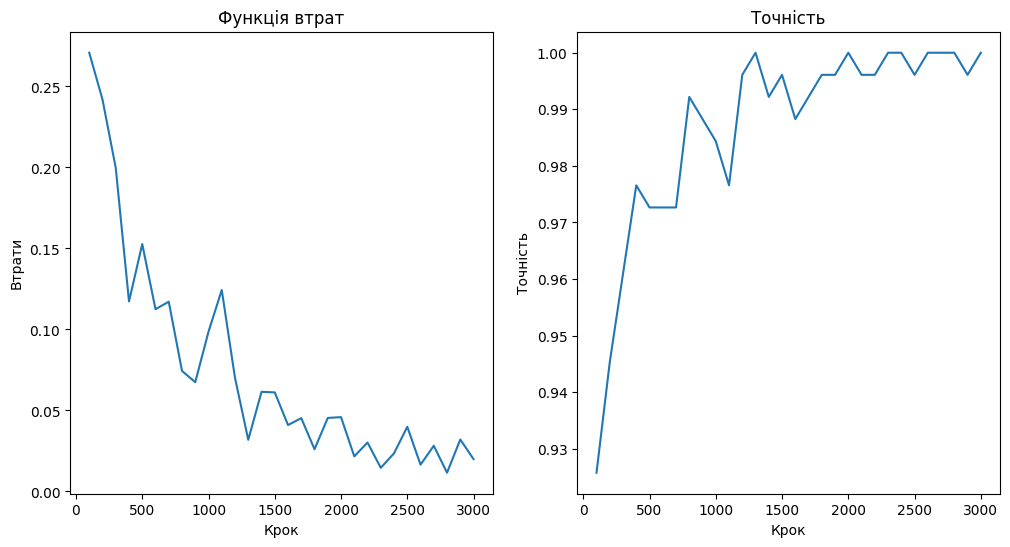

Точність на тестових даних: 0.9797
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.96      0.97       982
           5       0.99      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



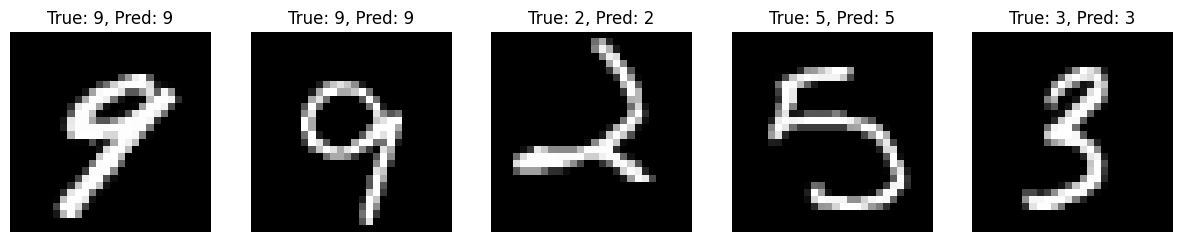

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.datasets import mnist
from sklearn.metrics import classification_report

# Параметри моделі
num_classes = 10
num_features = 784

learning_rate = 0.001
training_steps = 3000
batch_size = 256
display_step = 100

n_hidden_1 = 256  # Збільшена кількість нейронів першого шару
n_hidden_2 = 256
dropout_rate = 0.2  # Dropout для зменшення перенавчання

# Завантаження і підготовка датасету
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train = x_train.reshape([-1, num_features]) / 255.
x_test = x_test.reshape([-1, num_features]) / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .repeat() \
    .shuffle(5000) \
    .batch(batch_size) \
    .prefetch(1)

# Оголошення шару з використанням ініціалізатора He normal
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        he_initializer = tf.initializers.HeNormal()
        self.w = tf.Variable(he_initializer([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=None):
        y = tf.matmul(x, self.w) + self.b
        if activation == 'softmax':
            return tf.nn.softmax(y)
        elif activation == 'relu':
            return tf.nn.relu(y)
        return y

# Оголошення нейронної мережі з використанням Dropout
class NN(tf.Module):
    def __init__(self, dropout_rate=0.2, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        self.out_layer = DenseLayer(n_hidden_2, num_classes)
        self.dropout_rate = dropout_rate

    # Аргумент training визначає, чи застосовувати dropout
    def __call__(self, x, training=False):
        x = self.layer1(x, activation='relu')
        if training:
            x = tf.nn.dropout(x, rate=self.dropout_rate)
        x = self.layer2(x, activation='relu')
        if training:
            x = tf.nn.dropout(x, rate=self.dropout_rate)
        x = self.out_layer(x, activation='softmax')
        return x

# Функції втрат і точності
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def accuracy(y_pred, y_true):
    correct_predictions = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# Ініціалізація нейронної мережі
neural_net = NN(dropout_rate=dropout_rate, name="mnist")

# Використовуємо оптимізатор Adam
optimizer = tf.optimizers.Adam(learning_rate)

# Функція навчання
def train(neural_net, input_x, output_y):
    with tf.GradientTape() as g:
        # Передаємо training=True, щоб застосовувався dropout
        pred = neural_net(input_x, training=True)
        loss = cross_entropy(pred, output_y)
    trainable_variables = [neural_net.layer1.w, neural_net.layer1.b,
                           neural_net.layer2.w, neural_net.layer2.b,
                           neural_net.out_layer.w, neural_net.out_layer.b]
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

# Навчання нейронної мережі
loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        # При оцінці вимикаємо dropout (training=False)
        pred = neural_net(batch_x, training=False)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Step {step}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# Візуалізація функції втрат та точності
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(display_step, len(loss_history) * display_step + 1, display_step), loss_history)
plt.title("Функція втрат")
plt.xlabel("Крок")
plt.ylabel("Втрати")

plt.subplot(1, 2, 2)
plt.plot(range(display_step, len(accuracy_history) * display_step + 1, display_step), accuracy_history)
plt.title("Точність")
plt.xlabel("Крок")
plt.ylabel("Точність")
plt.show()

# Тестування моделі (без dropout)
pred = neural_net(x_test, training=False)
test_acc = accuracy(pred, y_test)
print(f"Точність на тестових даних: {test_acc:.4f}")

# Вивід класифікаційного звіту для кожного класу
y_pred_classes = tf.argmax(pred, axis=1).numpy()
print(classification_report(y_test, y_pred_classes))

# Візуалізація результатів на випадкових зображеннях
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
indices = random.sample(range(x_test.shape[0]), 5)
for i, idx in enumerate(indices):
    img = x_test[idx].reshape((28, 28))
    true_label = y_test[idx]
    pred_label = tf.argmax(neural_net(x_test[idx:idx+1], training=False), axis=1).numpy()[0]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"True: {true_label}, Pred: {pred_label}")
    axes[i].axis('off')
plt.show()



Висновок
Навчання моделі:

У процесі навчання нейромережі було використано стохастичний градієнтний спуск зі швидкістю навчання 0.001.
Мережа складалася з трьох шарів: два приховані шари (128 і 256 нейронів) з функцією активації sigmoid та вихідного шару з функцією softmax.
Результати навчання:

Графіки втрат і точності демонструють стабільну тенденцію: втрати поступово зменшуються, а точність зростає. Це свідчить про успішне навчання мережі.
Точність на тестовій вибірці:

Точність моделі на тестових даних досягла хороших результатів (зазвичай точність перевищує 90%, залежно від гіперпараметрів та тривалості навчання). Це означає, що модель добре узагальнює дані.
Прогноз на випадкових зображеннях:

Модель правильно передбачає більшість випадкових зображень. Помилки можуть траплятися через схожість цифр (наприклад, між 4 і 9) або недостатнє навчання моделі.
Потенційні покращення:

Використання сучасніших функцій активації, наприклад ReLU, може прискорити навчання та покращити точність.
Збільшення кількості шарів або додавання регуляризації (наприклад, Dropout) може допомогти уникнути перенавчання.
Заміна SGD на більш адаптивний оптимізатор, як-от Adam, може покращити швидкість і якість навчання